In [1]:
import tensorflow as tf
import chess
import chess.engine
import random
#import cupy as np
import numpy
import tensorflow as tf


# this function will create our x (board)
def random_board(max_depth=200):
  board = chess.Board()
  depth = random.randrange(0, max_depth)

  for _ in range(depth):
    all_moves = list(board.legal_moves)
    random_move = random.choice(all_moves)
    board.push(random_move)
    if board.is_game_over():
      break

  return board


# this function will create our f(x) (score)
stockFish13path = 'C:\\Users\\garre\\chess\\ChessAIECE528\\stockfish\\13\\bin\\stockfish_20011801_x64.exe'
def stockfish(board, depth):
  with chess.engine.SimpleEngine.popen_uci(stockFish13path) as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    score = result['score'].white().score()
    return score

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping: no known devices.


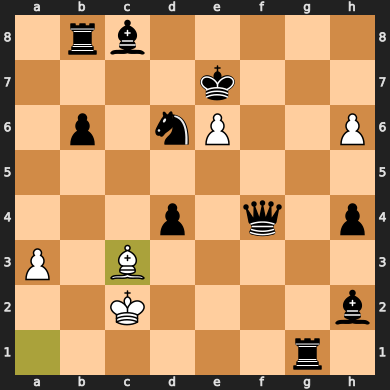

In [3]:
board = random_board()
board

In [4]:
print(stockfish(board, 15))

None


The Idea is that the Deep Learning Network will predict this score based on the positions of the pieces on the board.

# Creating the dataset

Now we need to convert the board representation to something meaningful.
A 3d matrix of sizes **8 x 8 x 14** where 8x8 repersents the board and the 14 represents the 7 different pieces 

In [5]:
squares_index = {
  'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7
}


# example: h3 -> 17
def square_to_index(square):
  letter = chess.square_name(square)
  return 8 - int(letter[1]), squares_index[letter[0]]


def split_dims(board):
  # this is the 3d matrix
  board3d = numpy.zeros((14, 8, 8), dtype=numpy.int8)

  # here we add the pieces's view on the matrix
  for piece in chess.PIECE_TYPES:
    for square in board.pieces(piece, chess.WHITE):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece - 1][7 - idx[0]][idx[1]] = 1
    for square in board.pieces(piece, chess.BLACK):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece + 5][7 - idx[0]][idx[1]] = 1

  # add attacks and valid moves too
  # so the network knows what is being attacked
  aux = board.turn
  board.turn = chess.WHITE
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[12][i][j] = 1
  board.turn = chess.BLACK
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[13][i][j] = 1
  board.turn = aux

  return board3d

In [6]:
t = split_dims(board)
t.shape

(14, 8, 8)

Now, all we have to do is call **random_board()** to create random boards, **stockfish()** to get a score for how good each board is for white.

Then we convert each board to a 3d matrix using **split_dims()**, now creating the dataset is easy!

# TensorFlow!

In [7]:
#import tensorflow.keras
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers


def build_model(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = board3d
  for _ in range(conv_depth):
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(64, 'relu')(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

Skip connections (residual network) will likely improve the model for deeper connections. If you want to test the residual model, check the code below.

In [8]:
def build_model_residual(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(board3d)
  for _ in range(conv_depth):
    previous = x
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, previous])
    x = layers.Activation('relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(200, 'relu')(x)
  x = layers.Dropout(.5)(x)
  x = layers.Dense(200, 'relu')(x)
  x = layers.Dropout(.5)(x)
  x = layers.Dense(200, 'relu')(x)
  x = layers.Dropout(.5)(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

In [9]:
model = build_model_residual(32, 4)

# It's training time!

In [10]:
import tensorflow.keras.callbacks as callbacks
from sklearn.model_selection import train_test_split

def get_dataset():
	container = numpy.load('dataset.npz')
	b, v = container['b'], container['v']
	v = numpy.asarray(v / abs(v).max() / 2 + 0.5, dtype=numpy.float32) # normalization (0 - 1) #should we be normalizing. 
	return b, v


boardstates, evaluation  = get_dataset()
x_train, x_test, y_train, y_test = train_test_split(boardstates, evaluation, test_size = 0.2, random_state = random.randint(1, 9999))
x_train.transpose()
print(x_train.shape)
print(y_train.shape)

(1200000, 14, 8, 8)
(1200000,)


In [11]:
y_train

array([0.50512356, 0.49763915, 0.43711072, ..., 0.44474584, 0.41355234,
       0.43716094], dtype=float32)

In [12]:
x = numpy.empty(10)
y = numpy.empty(10)
numpy.savez('test.npz', x, y)
container = numpy.load('test.npz')
container.files
a = container['arr_0']
a.size

10

In [13]:
def createData(NumberOfTrainings):
    outfile = 'chessdata1.npz'
    xdata = numpy.empty([NumberOfTrainings, 14,8,8])
    ylables = numpy.empty(NumberOfTrainings)
    for i in range(NumberOfTrainings):
        if(i%10000 == 0):
            numpy.savez(outfile, xdata, ylables)
            print(i)
        board = random_board()
        y = (stockfish(board, 15))  
        x = split_dims(board)
        ylables[i] = y
        xdata[i] = x
    numpy.savez(outfile, xdata, ylables)
    return xdata, ylables
#x_temp, y_temp = createData(250000)
#print(x_temp.shape)
#print(y_temp.shape)
#container = numpy.load('chessdata1.npz')
#x_test2 = container['arr_0']
#y_test2 = container['arr_1']

In [14]:
#print(x_test2.shape)
#print(y_test2.shape)
#print(y_test2[800]) #the ytest2 will be 0 if there is no data in it 

NameError: name 'x_test2' is not defined

In [15]:
#from tensorflow.keras.callbacks import ModelCheckpoint
#model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error',  metrics=['mae', 'mse'])
#model.summary()
#checkpoint_filepath = '\\tmp\\checkpoint\\'
#model_checkpointing_callback = ModelCheckpoint(
#    filepath = checkpoint_filepath,
#    save_best_only= True,
#)
#history = model.fit(x_train, y_train,
#          batch_size=2048,
#          epochs=1000,
#          verbose=1,
#          validation_split=0.1,
#          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
#                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4),model_checkpointing_callback])
#
#model.save('modeltestclustored.h5')

In [16]:
#loss, mae, mse = model.evaluate(x_test, y_test, verbose=2)

#print("Testing set Mean Abs Error: {:5.5f} ".format(mae))

# Playing with the AI

In [211]:
from tensorflow.keras import models
model = models.load_model('q_aware.h5')

ValueError: Unknown layer: 'QuantizeLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [213]:
with tfmot.quantization.keras.quantize_scope():
    model = tf.keras.models.load_model('q_aware.h5')

In [216]:
model = tf.keras.models.load_model('modelclustored2.h5')

In [217]:
# used for the minimax algorithm
def minimax_eval(board):
  board3d = split_dims(board)
  board3d = numpy.expand_dims(board3d, 0)
  return model(board3d)[0][0]


def minimax(board, depth, alpha, beta, maximizing_player):
  if depth == 0 or board.is_game_over():
    return minimax_eval(board)
  
  if maximizing_player:
    max_eval = -numpy.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, False)
      board.pop()
      max_eval = max(max_eval, eval)
      alpha = max(alpha, eval)
      if beta <= alpha:
        break
    return max_eval
  else:
    min_eval = numpy.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, True)
      board.pop()
      min_eval = min(min_eval, eval)
      beta = min(beta, eval)
      if beta <= alpha:
        break
    return min_eval


# this is the actual function that gets the move from the neural network
def get_ai_move(board, depth):
  max_move = None
  max_eval = -numpy.inf

  for move in board.legal_moves:
    board.push(move)
    eval = minimax(board, depth - 1, -numpy.inf, numpy.inf, False)
    board.pop()
    if eval > max_eval:
      max_eval = eval
      max_move = move
  
  return max_move

In [218]:
# Move by move testing code AI(white) vs Stockfish(black)
board = chess.Board()

with chess.engine.SimpleEngine.popen_uci(stockFish13path) as engine:
    moves = 0
    while True:
        move = get_ai_move(board, 2)
        board.push(move)
        moves +=1
        print(f'\n{board}')
        if board.is_game_over():
            print('white won game_over with ' + str(moves) + ' moves')
            break
        move = engine.analyse(board, chess.engine.Limit(time=1), info=chess.engine.INFO_PV)['pv'][0]
        board.push(move)
        moves +=1
        print(f'\n{board}')
        if board.is_game_over():
            print('black won game_over with '+ str(moves) +' moves')
            break


r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K B N R

r n b q k b n r
p p p p . p p p
. . . . p . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K B N R

r n b q k b n r
p p p p . p p p
. . . . p . . .
. . . . . . . .
. . . . . . . .
. . . . P N . .
P P P P . P P P
R N B Q K B . R

r n b q k b n r
p p p . . p p p
. . . . p . . .
. . . p . . . .
. . . . . . . .
. . . . P N . .
P P P P . P P P
R N B Q K B . R

r n b q k b n r
p p p . . p p p
. . . . p . . .
. . . p . . . .
. . . . . . . .
. . N . P N . .
P P P P . P P P
R . B Q K B . R

r n b q k b . r
p p p . . p p p
. . . . p n . .
. . . p . . . .
. . . . . . . .
. . N . P N . .
P P P P . P P P
R . B Q K B . R

r n b q k b . r
p p p . . p p p
. . . . p n . .
. . . p . . . .
. . . . . . . .
. . N . P N . .
P P P P B P P P
R . B Q K . . R

r n b q k b . r
p p . . . p p p
. . . . p n . .
. . p p . . . .
. . . . . . . .
. . N . P N . .


In [29]:
# Move by move testing code AI(white) vs Stockfish(black)
board = chess.Board()
from IPython.display import clear_output

with chess.engine.SimpleEngine.popen_uci(stockFish13path) as engine:
    while True:
        clear_output(wait=True)
        move = get_ai_move(board, 1)
        board.push(move)
        print(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('game_over')
            break
        input_var = input()
        move = chess.Move.from_uci(input_var)
        board.push(move)
        print(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('game_over')
            break

e2e3

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K B N R
j


ValueError: expected uci string to be of length 4 or 5: 'j'

Reducing model size

In [48]:
import tempfile
import zipfile
import os
origModelFile = 'model.h5'

model = tf.keras.models.load_model(origModelFile)
model.summary()

_, zip3 = tempfile.mkstemp('.zip')
with zipfile.ZipFile(zip3, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(origModelFile)
print("Size of the original model before comression : %.2f MB" %(os.path.getsize(origModelFile) / float(2**20)))

print("Size of the original model after comression : %.2f MB" %(os.path.getsize(zip3) / float(2**20)))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d (Conv2D)             (None, 14, 8, 32)         2336      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 dense (Dense)               (None, 64)                229440

In [61]:
def save_model_file(model):
  _, keras_file = tempfile.mkstemp('.h5') 
  model.save(keras_file, include_optimizer=False)
  return keras_file

def get_gzipped_model_size(model):
  # It returns the size of the gzipped model in bytes.
  import os
  import zipfile

  keras_file = save_model_file(model)

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(keras_file)
  return os.path.getsize(zipped_file)

def save_model_weights(model):
  _, pretrained_weights = tempfile.mkstemp('.h5')
  model.save_weights(pretrained_weights)
  return pretrained_weights

def setup_pretrained_weights():
  #model= setup_model()
  model = tf.keras.models.load_model(origModelFile)
  pretrained_weights = save_model_weights(model)
  return pretrained_weights

pretrained_weights = setup_pretrained_weights()

In [63]:
cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 10,
  'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS
}

model = tf.keras.models.load_model(origModelFile)
model.load_weights(pretrained_weights)

clustered_model = cluster_weights(model, **clustering_params)

clustered_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 cluster_conv2d (ClusterWeig  (None, 14, 8, 32)        4650      
 hts)                                                            
                                                                 
 cluster_conv2d_1 (ClusterWe  (None, 14, 8, 32)        18474     
 ights)                                                          
                                                                 
 cluster_conv2d_2 (ClusterWe  (None, 14, 8, 32)        18474     
 ights)                                                          
                                                                 
 cluster_conv2d_3 (ClusterWe  (None, 14, 8, 32)        18474     
 ights)                                                      

In [64]:


clustered_model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error',  metrics=['mae', 'mse'])
#model.summary()
#checkpoint_filepath = '\\tmp\\checkpoint\\'
#model_checkpointing_callback = ModelCheckpoint(
#    filepath = checkpoint_filepath,
#    save_best_only= True,

clustered_model.fit(
    x_train,
    y_train
)

final_model = tfmot.clustering.keras.strip_clustering(clustered_model)

print("final model")

37500/37500 [==============================] - 909s 24ms/step - loss: 4.6842e-04 - mae: 0.0135 - mse: 4.6842e-04
final model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d (Conv2D)             (None, 14, 8, 32)         2336      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 flatten (Flatten)           (None, 3584)              0         
  

In [66]:
final_model.summary()
final_model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error',  metrics=['mae', 'mse'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d (Conv2D)             (None, 14, 8, 32)         2336      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 dense (Dense)               (None, 64)                229440

In [67]:
print("\n")
print("Size of gzipped clustered model without stripping: %.2f MB" 
      % (get_gzipped_model_size(clustered_model) / float(2**20)))
print("Size of gzipped clustered model with stripping: %.2f MB" 
      % (get_gzipped_model_size(final_model) / float(2**20)))



Size of gzipped clustered model without stripping: 1.09 MB
Size of gzipped clustered model with stripping: 0.14 MB


In [71]:
from tensorflow.keras.callbacks import ModelCheckpoint
final_model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error',  metrics=['mae', 'mse'])
final_model.summary()
#checkpoint_filepath = '\\tmp\\checkpoint\\'
#model_checkpointing_callback = ModelCheckpoint(
#    filepath = checkpoint_filepath,
#    save_best_only= True,
#)
history = final_model.fit(x_train, y_train,
          batch_size=2048,
          epochs=1000,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4)])

final_model.save('modeltestclustored.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d (Conv2D)             (None, 14, 8, 32)         2336      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 dense (Dense)               (None, 64)                229440

In [73]:
loss, mae, mse = final_model.evaluate(x_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.5f} ".format(mae))

9375/9375 - 28s - loss: 3.4290e-04 - mae: 0.0107 - mse: 3.4290e-04 - 28s/epoch - 3ms/step
Testing set Mean Abs Error: 0.01070 


In [86]:
for i in range(len(final_model.weights)):
    final_model.weights[i]._handle_name = final_model.weights[i].name + "_" + str(i)
final_model.save('modelclustored2.h5')

ValueError: Unable to create dataset (name already exists)

In [ ]:
print("\n")
print("Size of gzipped clustered model without stripping: %.2f MB" 
      % (get_gzipped_model_size(clustered_model) / float(2**20)))
print("Size of gzipped clustered model with stripping: %.2f MB" 
      % (get_gzipped_model_size(final_model) / float(2**20)))

In [87]:
for i, w in enumerate(final_model.weights): print(i, w.name)

0 conv2d/bias:0_0_0_0_0
1 conv2d_1/bias:0_1_1_1_1
2 conv2d_2/bias:0_2_2_2_2
3 conv2d_3/bias:0_3_3_3_3
4 dense/bias:0_4_4_4_4
5 dense_1/bias:0_5_5_5_5
6 kernel:0_6_6
7 bias:0_7_7
8 kernel:0_8_8
9 bias:0_9_9
10 kernel:0_10_10
11 bias:0_11_11


In [92]:
def setup_pretrained_weights():
  model = tf.keras.models.load_model('modelclustored2.h5')

  model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error',  metrics=['mae', 'mse'])

  model.fit(x_train, y_train)

  _, pretrained_weights = tempfile.mkstemp('.tf')

  model.save_weights(pretrained_weights)

  return pretrained_weights

In [98]:
##Pruning 
base_model = tf.keras.models.load_model('modelclustored2.h5')
base_model.load_weights(pretrained_weights) # optional but recommended.

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(base_model)
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    # Log sparsity and other metrics in Tensorboard.
    #tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir),
    callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
    callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4)
    
]

model_for_pruning.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error',  metrics=['mae', 'mse'])


model_for_pruning.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 prune_low_magnitude_conv2d   (None, 14, 8, 32)        4642      
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_conv2d_  (None, 14, 8, 32)        18466     
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_conv2d_  (None, 14, 8, 32)        18466     
 2 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_conv2d_  (None, 14, 8, 32)        18466     
 3 (PruneLowMagnitude)                                       

In [99]:
model_for_pruning.fit(
    x_train,
    y_train,
    callbacks=callbacks,
    epochs=1000,
)

Epoch 1/1000
37500/37500 [==============================] - 550s 15ms/step - loss: 4.3243e-04 - mae: 0.0127 - mse: 4.3243e-04 - lr: 5.0000e-04
Epoch 2/1000
37500/37500 [==============================] - 528s 14ms/step - loss: 3.9370e-04 - mae: 0.0121 - mse: 3.9370e-04 - lr: 5.0000e-04
Epoch 3/1000
37500/37500 [==============================] - 549s 15ms/step - loss: 3.7713e-04 - mae: 0.0118 - mse: 3.7713e-04 - lr: 5.0000e-04
Epoch 4/1000
37500/37500 [==============================] - 546s 15ms/step - loss: 3.6487e-04 - mae: 0.0116 - mse: 3.6487e-04 - lr: 5.0000e-04
Epoch 5/1000
37500/37500 [==============================] - 560s 15ms/step - loss: 3.5447e-04 - mae: 0.0115 - mse: 3.5447e-04 - lr: 5.0000e-04
Epoch 6/1000
37500/37500 [==============================] - 558s 15ms/step - loss: 3.4556e-04 - mae: 0.0113 - mse: 3.4556e-04 - lr: 5.0000e-04
Epoch 7/1000
37500/37500 [==============================] - 559s 15ms/step - loss: 3.3858e-04 - mae: 0.0112 - mse: 3.3858e-04 - lr: 5.0000e-04

In [102]:
final_model.save('model_for_pruning2.h5')

ValueError: Unable to create dataset (name already exists)

In [201]:
model = tf.keras.models.load_model('modelclustored2.h5')
loss, mae, mse = model.evaluate(x_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.5f} ".format(mae))

9375/9375 - 48s - loss: 3.4290e-04 - mae: 0.0107 - mse: 3.4290e-04 - 48s/epoch - 5ms/step
Testing set Mean Abs Error: 0.01070 


In [192]:
def representative_dataset():
   for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    print([input_value])
    yield [input_value]

In [193]:
my_signature = interpreter.get_signature_runner()
output = my_signature(tf.constant([1.0], shape=(1,10), dtype=tf.float32))

TypeError: __call__() takes 1 positional argument but 2 were given

In [194]:
#newx_test = 
#for i in x_test[i]
#    for j in x_test[i][j]
#        for k in x_test[i][j][k]
#            for m in x_test[i][j][k][m]
                

In [200]:
keras_model = tf.keras.models.load_model('modelclustored2.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset 
converter.inference_input_type = tf.uint8
#should only quantize the fixed params like weights 

tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\garre\AppData\Local\Temp\tmpyf8bl1lw\assets


INFO:tensorflow:Assets written to: C:\Users\garre\AppData\Local\Temp\tmpyf8bl1lw\assets
C:\School\CS345\lib\site-packages\tensorflow\lite\python\convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


[<tf.Tensor: shape=(1, 14, 8, 8), dtype=int16, numpy=
array([[[[0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0,

ValueError: Cannot set tensor: Got value of type INT16 but expected type FLOAT32 for input 0, name: serving_default_input_1:0 

In [197]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [164]:
interpreter.get_input_details()

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([ 1, 14,  8,  8]),
  'shape_signature': array([-1, 14,  8,  8]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [167]:
type(x_test[0][0][0][0])


numpy.int16

In [153]:
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0] 


total_seen = 0
running_mse = 0
running_mae = 0

for board, evaluation in zip(x_test, y_test):
    total_seen += 1
    #print(output_index)
    interpreter.set_tensor(input_details["index"], board)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    running_mse +=(abs(prediction - evaluation) * abs(prediction - evaluation))
    running_mae +=(abs(prediction - evaluation))
    
    if total_seen % 1000 == 0:
            print(type(prediction))
            print('MSE after %i boards: %3f' %(total_seen, float(running_mse) / float(total_seen)))

float(running_mse) / float(total_seen)

ValueError: Cannot set tensor: Got value of type INT16 but expected type FLOAT32 for input 0, name: serving_default_input_1:0 

In [150]:
print((prediction[0][0]))
prediction.size

1.0


1

In [127]:
y_test[0]

0.5936809

NameError: name 'sizeof' is not defined

In [202]:
y_test[0]

0.5936809

In [207]:
model = tf.keras.models.load_model('modelclustored2.h5')

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error',  metrics=['mae', 'mse'])

q_aware_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 quantize_layer_1 (QuantizeL  (None, 14, 8, 8)         3         
 ayer)                                                           
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 14, 8, 32)        2403      
 erV2)                                                           
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 14, 8, 32)        9315      
 pperV2)                                                         
                                                                 
 quant_conv2d_2 (QuantizeWra  (None, 14, 8, 32)        9315      
 pperV2)                                                     

In [208]:
#model = tf.keras.models.load_model('modelclustored2.h5')
model = tf.keras.models.load_model('modelclustored2.h5')
loss, mae, mse = q_aware_model.evaluate(x_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.5f} ".format(mae))

9375/9375 - 57s - loss: 0.0165 - mae: 0.1142 - mse: 0.0165 - 57s/epoch - 6ms/step
Testing set Mean Abs Error: 0.11421 


In [209]:
loss, mae, mse = model.evaluate(x_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.5f} ".format(mae))

9375/9375 - 47s - loss: 3.4290e-04 - mae: 0.0107 - mse: 3.4290e-04 - 47s/epoch - 5ms/step
Testing set Mean Abs Error: 0.01070 


In [210]:
q_aware_model.save('q_aware.h5')

In [219]:
print("\n")
print("Size of gzipped clustered model without quant: %.2f MB" 
      % (get_gzipped_model_size(q_aware_model) / float(2**20)))
print("Size of gzipped clustered model with quant: %.2f MB" 
      % (get_gzipped_model_size(model) / float(2**20)))



Size of gzipped clustered model without stripping: 0.54 MB
Size of gzipped clustered model with stripping: 0.54 MB
